
# Logistic Regression with GridSearchCV

Logistic regression is a good fit for screenng because it is simple, explainable, and gives a clear risk score instead of a hard yes/no. You can see how each input nudges the risk toward malignant or benign, which makes the result easier to trust. Since we get a risk score, we can choose a cutoff that catches more real cancers, even if it means a few extra follow ups, reducing the chance we miss someone who needs care. It trains quickly, stays stable on small tabular data, and is easy to ship as a small web service we can build later on. 

- Base model: `make_pipeline(StandardScaler(), LogisticRegression(random_state=42))`
- Param grid with multiple solvers, penalties, and C values
- GridSearchCV scored by F2 (prioritize recall/positive case) with cross-validation
- Final evaluation on the test set


In [2]:
# Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, datetime as dt
from pathlib import Path
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score, make_scorer, fbeta_score, average_precision_score, roc_auc_score, 
                            confusion_matrix, classification_report, precision_recall_curve, RocCurveDisplay, auc, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib, json

Path("models").mkdir(parents=True, exist_ok=True)

In [3]:
# Load data
train = pd.read_csv(Path("data/processed", "train.csv"))
test  = pd.read_csv(Path("data/processed", "test.csv"))

TARGET = "diagnosis" 

X_tr = train.drop(columns=[TARGET])
y_tr = train[TARGET]
X_te = test.drop(columns=[TARGET])
y_te = test[TARGET]

print("Train:", X_tr.shape, "Test:", X_te.shape)
print("Class counts (train):", np.bincount(y_tr))
print("Class counts (test) :", np.bincount(y_te))

Train: (455, 30) Test: (114, 30)
Class counts (train): [285 170]
Class counts (test) : [72 42]


In [4]:
# Logistic Regression base model
log_Model = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))

# Hyperparamter Tuning

In [5]:
param_grid = [
    # liblinear: only l1 or l2
    {
        "logisticregression__solver": ["liblinear"],
        "logisticregression__penalty": ["l1", "l2"],
        "logisticregression__C": np.logspace(-1, 1, 20),
        "logisticregression__max_iter": [1500],
        "logisticregression__class_weight": [None, "balanced", {0:1, 1:1.5}, {0:1, 1:2.0}],
    },
    # lbfgs/newton-cg/newton-cholesky/sag/saga: l2 or *no penalty* 
    {
        "logisticregression__solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"],
        "logisticregression__penalty": ["l2", None],
        "logisticregression__C": np.logspace(-1, 1, 20),
        "logisticregression__max_iter": [1500],
        "logisticregression__class_weight": [None, "balanced", {0:1, 1:1.5}, {0:1, 1:2.0}],
    },
    # saga + elasticnet (only place we pass l1_ratio)
    {
        "logisticregression__solver": ["saga"],
        "logisticregression__penalty": ["elasticnet"],
        "logisticregression__l1_ratio": [0.2, 0.5, 0.8],
        "logisticregression__C": np.logspace(-1, 1, 20),
        "logisticregression__max_iter": [1500],
        "logisticregression__class_weight": [None, "balanced", {0:1, 1:1.5}, {0:1, 1:2.0}],
    },
]

In [6]:
# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# F2 scorer for recall-weighted optimization
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
log_model_grid = GridSearchCV(log_Model, param_grid, scoring={"recall": "recall", "f2": f2_scorer}, refit='recall', cv=kf,
                  n_jobs=-1, verbose=2, error_score=np.nan)
log_model_grid.fit(X_tr, y_tr)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logisticregression__C': array([ 0.1 ... 10. ]), 'logisticregression__class_weight': [None, 'balanced', ...], 'logisticregression__max_iter': [1500], 'logisticregression__penalty': ['l1', 'l2'], ...}, {'logisticregression__C': array([ 0.1 ... 10. ]), 'logisticregression__class_weight': [None, 'balanced', ...], 'logisticregression__max_iter': [1500], 'logisticregression__penalty': ['l2', None], ...}, ...]"
,scoring,"{'f2': make_scorer(f..., pos_label=1), 'recall': 'recall'}"
,n_jobs,-1
,refit,'recall'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Missing a cancer is far costlier than an extra follow up test. Therefore, we optimize F2 to prioritize sensitivity to catch more true positives even if it means a few more false alerts.

In [8]:
print("Tuned Logistic Regression Parameters: {}".format(log_model_grid.best_params_))
print("Best score is {}".format(log_model_grid.best_score_))

Tuned Logistic Regression Parameters: {'logisticregression__C': np.float64(0.1), 'logisticregression__class_weight': {0: 1, 1: 2.0}, 'logisticregression__max_iter': 1500, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best score is 0.9705882352941178


In [9]:
# Final evaluation on test set
log_best = log_model_grid.best_estimator_
y_prob = log_best.predict_proba(X_te)[:,1]
y_pred = (y_prob >= 0.50).astype(int)

f2   = fbeta_score(y_te, y_pred, beta=2.0, zero_division=0)
auprc= average_precision_score(y_te, y_prob) 
auroc= roc_auc_score(y_te, y_prob) 
cm   = confusion_matrix(y_te, y_pred, labels=[1,0])

print({
    "F2": round(f2,3),
    "AUPRC": round(auprc,3),
    "AUROC": round(auroc,3),
    "confusion_matrix": cm.tolist()
})

print("\nClassification report:\n", classification_report(y_te, y_pred, zero_division=0))


{'F2': 0.976, 'AUPRC': 0.997, 'AUROC': 0.998, 'confusion_matrix': [[41, 1], [1, 71]]}

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



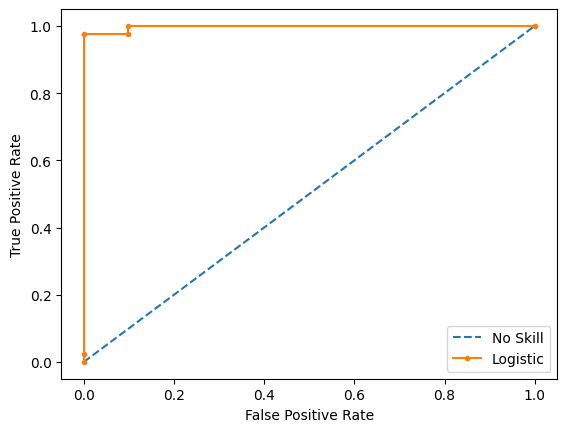

In [10]:
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_te, y_prob)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [11]:
precision, recall, thresholds = precision_recall_curve(y_te, y_prob)
auc_score = auc(recall, precision)

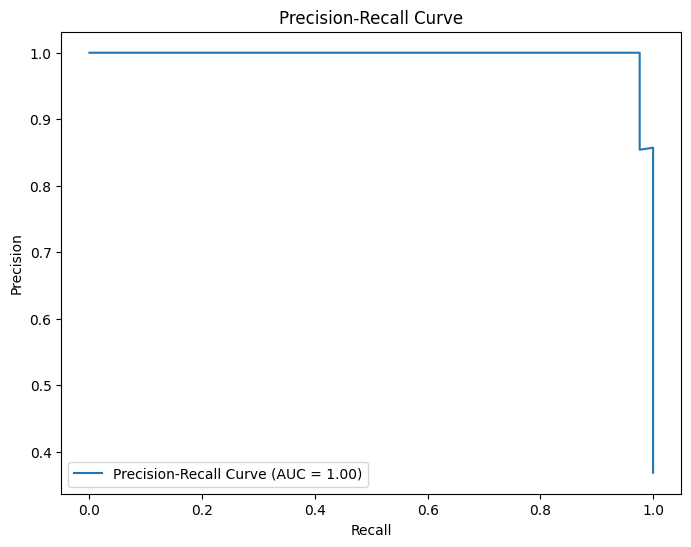

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [13]:
tp, fn, fp, tn = confusion_matrix(y_te, y_pred, labels=[1,0]).ravel()

metrics = {
    "F2":        float(fbeta_score(y_te, y_pred, beta=2, pos_label=1)),
    "recall":    float(recall_score(y_te, y_pred, pos_label=1)),
    "precision": float(precision_score(y_te, y_pred, pos_label=1, zero_division=0)),
    "AUPRC":     float(average_precision_score(y_te, y_prob)),
    "AUROC":     float(roc_auc_score(y_te, y_prob)),
    "confusion_matrix": {"TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn)}
}

In [ ]:
# Save model
features = list(X_tr.columns)
ex_rec = X_te.iloc[0].to_dict()
meta = {
    "model_name": "LogisticRegression",
    "model_version": dt.date.today().isoformat(),
    "pos_label": 1,
    "features": features,                 # strict feature order for the API
    "threshold": 0.50,        # F2-optimal threshold picked on VALIDATION
    "test_metrics": metrics,              # nice for README and /version
    "example_record": {k: float(ex_rec[k]) for k in features}
}
with open("models/logreg_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved: models/logisticregression.joblib and models/logreg_meta.json")

Saved: models/logisticregression.joblib and models/logreg_meta.json


: 